In [1]:
import pandas as pd
data = pd.read_csv('ai4i2020.csv')


In [2]:
print(data.head())
print(data.info())
print(data.describe())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [3]:
print(data.isnull().sum())


UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


In [4]:
data = data.drop(['UDI', 'Product ID'], axis=1)


In [5]:
data = pd.get_dummies(data, columns=['Type'])


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_to_scale = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])


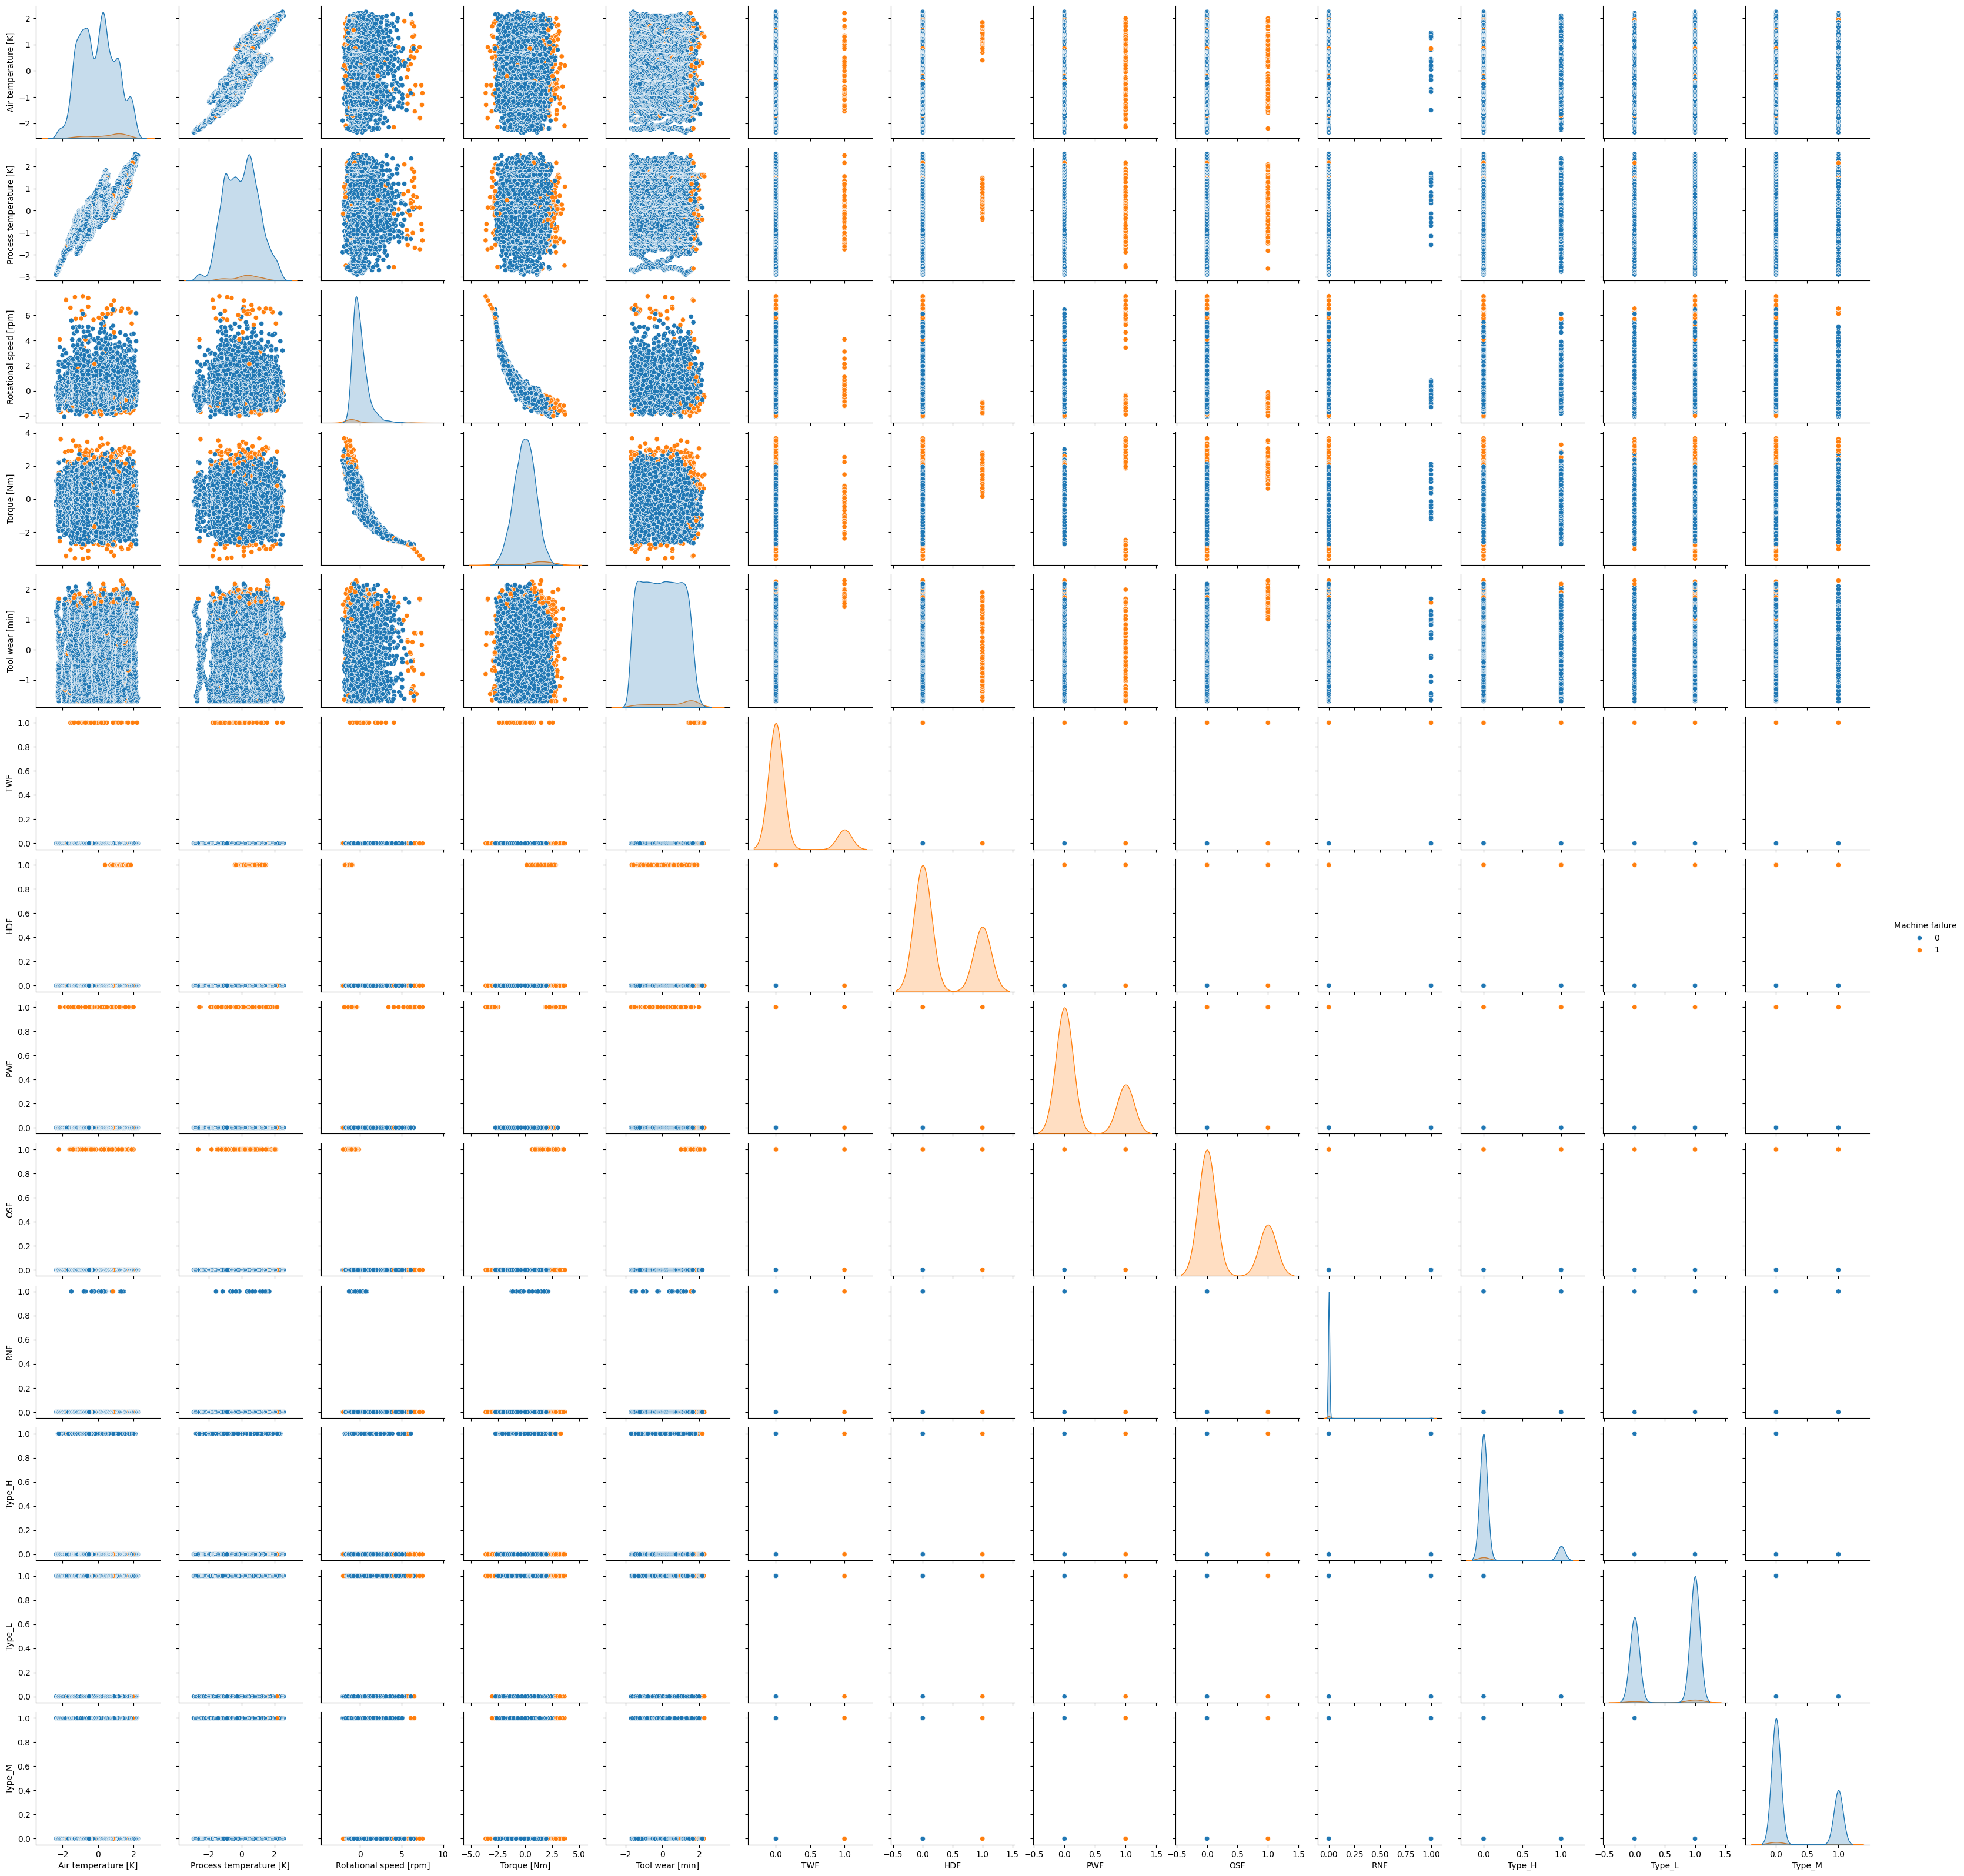

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data, hue='Machine failure')
plt.show()


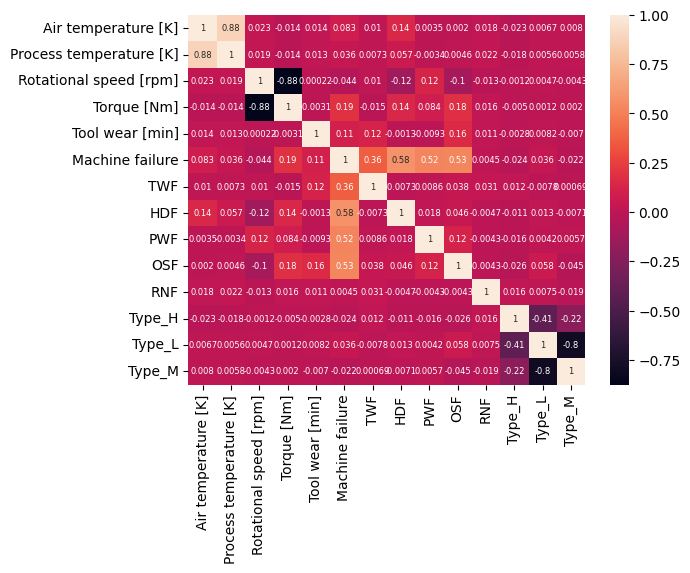

In [8]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"size":6})
plt.show()

In [9]:
print(data['Machine failure'].value_counts())

Machine failure
0    9661
1     339
Name: count, dtype: int64


In [14]:
from imblearn.over_sampling import SMOTE

X = data.drop('Machine failure', axis=1)
y = data['Machine failure']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [17]:
y_pred = model.predict(X_test)


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1934
           1       1.00      0.99      1.00      1931

    accuracy                           1.00      3865
   macro avg       1.00      1.00      1.00      3865
weighted avg       1.00      1.00      1.00      3865



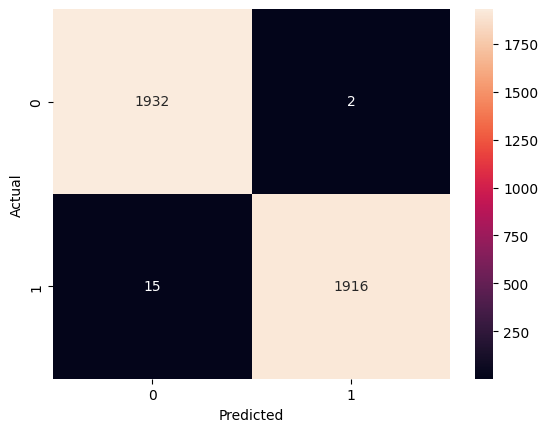

In [19]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [20]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC Score:', roc_auc)


ROC AUC Score: 0.9999330576020591


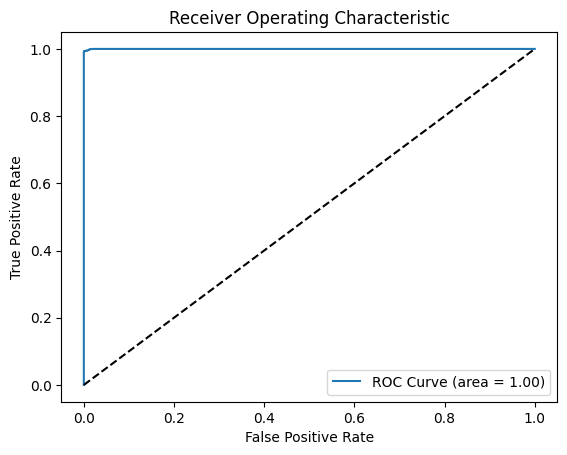

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


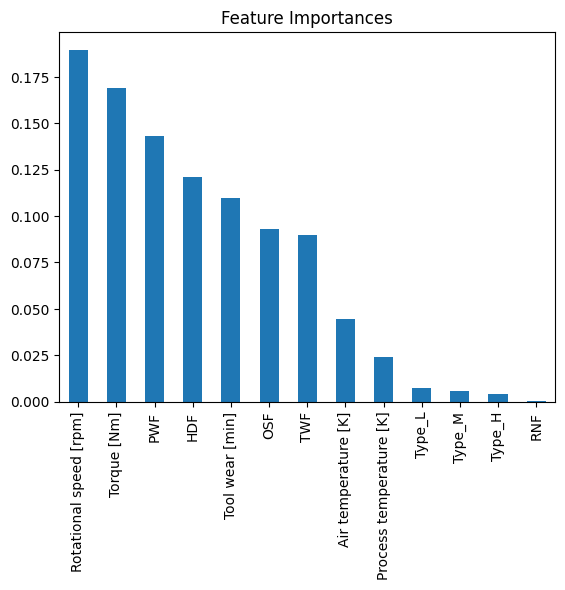

In [22]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_) 

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [24]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [25]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='f1')
print('Cross-Validation F1 Scores:', cv_scores)
print('Mean F1 Score:', cv_scores.mean())


Cross-Validation F1 Scores: [0.99325726 0.99354506 0.84943621 0.99532468 0.99349467]
Mean F1 Score: 0.9650115745550828


In [26]:
import pandas as pd

# Example: New readings for the machine (replace these with your actual new readings)
new_data = {
    'Air temperature [K]': [300],  # Example value
    'Process temperature [K]': [310],  # Example value
    'Rotational speed [rpm]': [1500],  # Example value
    'Torque [Nm]': [45],  # Example value
    'Tool wear [min]': [100],  # Example value
    'Type_H': [0],  # Example categorical data
    'Type_L': [1],  # Example categorical data
    'Type_M': [0],  # Example categorical data
    'TWF': [0],  # Tool wear failure (set as 0 if unknown)
    'HDF': [0],  # Heat dissipation failure
    'PWF': [0],  # Power failure
    'OSF': [0],  # Overstrain failure
    'RNF': [0],  # Random failure
}

# Convert the new data into a DataFrame
new_df = pd.DataFrame(new_data)

# Get the feature names from the model
feature_names = X.columns  # X is your training data

# Ensure the new DataFrame has the same columns in the same order as the training data
new_df = new_df[feature_names]

# Use the trained model to predict the output
prediction = best_model.predict(new_df)

# Check if the machine is failing or not
if prediction[0] == 1:
    print("The machine is predicted to fail.")
else:
    print("The machine is predicted to be healthy.")


The machine is predicted to fail.


In [27]:
# Get the probability of machine failure
probability = best_model.predict_proba(new_df)[:, 1]  # Probability of failure (class 1)

print(f"Probability of machine failure: {probability[0]:.2f}")


Probability of machine failure: 0.51


In [28]:
import pandas as pd

# Example: New readings for the machine 
new_data = {
    'Air temperature [K]': 300,  # Example value
    'Process temperature [K]': 350,  # Example value
    'Rotational speed [rpm]': 1500,  # Example value
    'Torque [Nm]': 20,  # Example value
    'Tool wear [min]': 10,  # Example value
    'Type_H': 0,  # Example categorical data
    'Type_L': 0,  # Example categorical data
    'Type_M': 0,  # Example categorical data
    'TWF': 0,  # Tool wear failure (set as 0 if unknown)
    'HDF': 0,  # Heat dissipation failure
    'PWF': 0,  # Power failure
    'OSF': 0,  # Overstrain failure
    'RNF': [0],  # Random failure
}

# Convert the new data into a DataFrame
new_df = pd.DataFrame(new_data)

# Get the feature names from the model
feature_names = X.columns  # X is your training data

# Ensure the new DataFrame has the same columns in the same order as the training data
new_df = new_df[feature_names]

# Use the trained model to predict the output
prediction = best_model.predict(new_df)

# Check if the machine is failing or not
if prediction[0] == 1:
    print("The machine is predicted to fail.")
else:
    print("The machine is predicted to be healthy.")


The machine is predicted to be healthy.


In [29]:
# Get the probability of machine failure
probability = best_model.predict_proba(new_df)[:, 1]  # Probability of failure (class 1)

print(f"Probability of machine failure: {probability[0]:.2f}")

Probability of machine failure: 0.44


In [30]:
# Example thresholds (these should be determined based on historical analysis)
thresholds = {
    'Air temperature [K]': 400,
    'Process temperature [K]': 500,
    'Rotational speed [rpm]': 1500,
    'Torque [Nm]': 80,
    'Tool wear [min]': 100
}

# Function to check for anomalies
def check_for_anomalies(new_readings, thresholds):
    anomalies = {}
    for feature, value in new_readings.items():
        if value > thresholds[feature]:
            anomalies[feature] = value
    return anomalies

# New readings example
new_readings = {
   'Air temperature [K]': 300,  # Example value
    'Process temperature [K]': 350,  # Example value
    'Rotational speed [rpm]': 1500,  # Example value
    'Torque [Nm]': 20,  # Example value
    'Tool wear [min]': 10
}

anomalies = check_for_anomalies(new_readings, thresholds)
if anomalies:
    print("Anomalies detected:", anomalies)
else:
    print("All features are within normal limits.")


All features are within normal limits.


In [31]:
# Example thresholds (these should be determined based on historical analysis)
thresholds = {
    'Air temperature [K]': 400,
    'Process temperature [K]': 500,
    'Rotational speed [rpm]': 150,
    'Torque [Nm]': 80,
    'Tool wear [min]': 100
}

# Function to check for anomalies
def check_for_anomalies(new_readings, thresholds):
    anomalies = {}
    for feature, value in new_readings.items():
        if value > thresholds[feature]:
            anomalies[feature] = value
    return anomalies

# New readings example
new_readings = {
  'Air temperature [K]': 300,  # Example value
    'Process temperature [K]': 310,  # Example value
    'Rotational speed [rpm]': 1500,  # Example value
    'Torque [Nm]': 45,  # Example value
    'Tool wear [min]': 100
}

anomalies = check_for_anomalies(new_readings, thresholds)
if anomalies:
    print("Anomalies detected:", anomalies)
else:
    print("All features are within normal limits.")


Anomalies detected: {'Rotational speed [rpm]': 1500}
